# One-qudit: High-dimensional phase estimation

In [1]:
import itertools

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.dv import DiscreteState, HGate, Phase

In [12]:
dim = 4

circuit = Circuit()

circuit.add(DiscreteState(wires=(0,), n=(0,)))
circuit.add(HGate(wires=(0,)))
circuit.add(Phase(wires=(0,), phi=0.1 * jnp.pi), "phase")
circuit.add(HGate(wires=(0,)))

params, static = eqx.partition(circuit, eqx.is_inexact_array)

print("The full circuit object:")
pprint(circuit)

print("The parameterized leaves of the Pytree:")
pprint(params)

print("The static leaves of the Pytree:")
pprint(static)

The full circuit object:


Circuit(
  ops={
│   0:
│   DiscreteState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   Phase(wires=(0,), phi=weak_f32[]),
│   3:
│   HGate(wires=(0,))
  }
)

The parameterized leaves of the Pytree:


Circuit(
  ops={
│   0:
│   DiscreteState(wires=(None,), n=[(None, (None,))]),
│   1:
│   HGate(wires=(None,)),
│   'phase':
│   Phase(wires=(None,), phi=weak_f32[]),
│   3:
│   HGate(wires=(None,))
  }
)

The static leaves of the Pytree:


Circuit(
  ops={
│   0:
│   DiscreteState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   Phase(wires=(0,), phi=None),
│   3:
│   HGate(wires=(0,))
  }
)

2025-03-05 22:58:28.492 | INFO     | squint.circuit:compile:114 -   Complete contraction:  a,ab,bc,cd->d
         Naive scaling:  4
     Optimized scaling:  3
      Naive FLOP count:  1.024e+3
  Optimized FLOP count:  1.920e+2
   Theoretical speedup:  5.333e+0
  Largest intermediate:  1.600e+1 elements
--------------------------------------------------------------------------------
scaling        BLAS                current                             remaining
--------------------------------------------------------------------------------
   2           GEMM                ab,a->b                            bc,cd,b->d
   3           GEMM              cd,bc->db                               b,db->d
   2           GEMM                db,b->d                                  d->d


[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 (0.0, 71.40007781982422)]

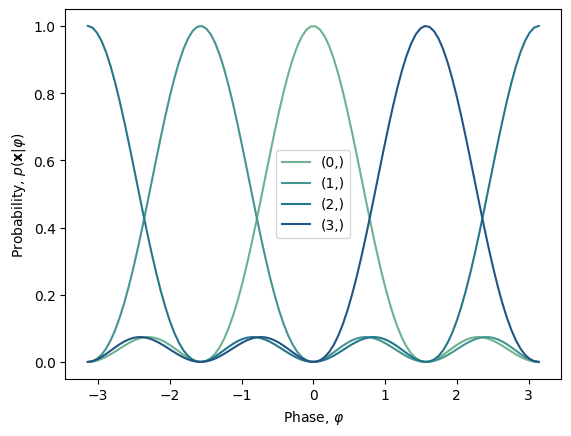

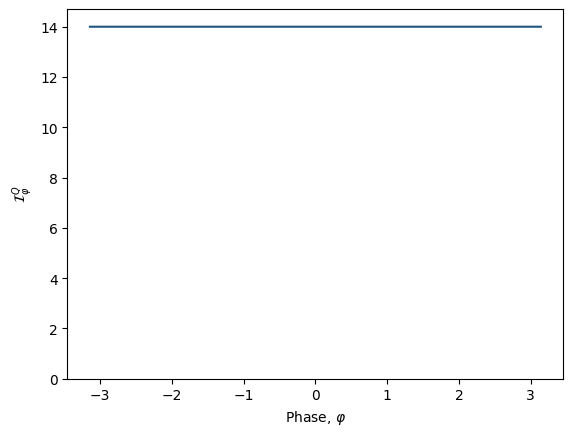

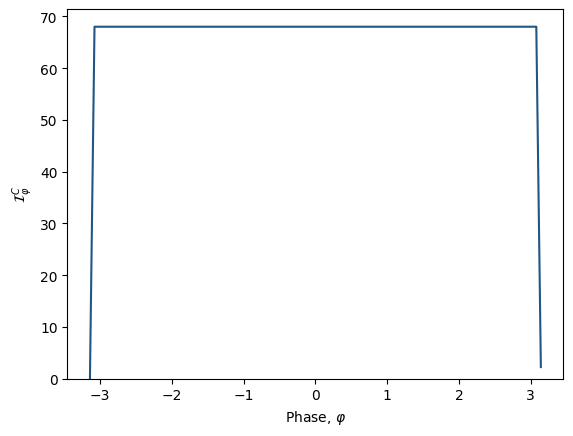

In [15]:
sim = circuit.compile(params, static, dim=dim, optimize="greedy")

get = lambda pytree: jnp.array([pytree.ops["phase"].phi])

phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].phi, params, jnp.expand_dims(phis, axis=1)
)

probs = eqx.filter_vmap(sim.prob.forward)(params)
cfims = eqx.filter_vmap(sim.prob.cfim, in_axes=(None, 0))(get, params)
qfims = eqx.filter_vmap(sim.amplitudes.qfim, in_axes=(None, 0))(get, params)

colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")


fig, ax = plt.subplots()
ax.plot(phis, qfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^Q$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)

fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(cfims)],
)